In [1]:
'''
=====Experiment=====
Dataset: UNSW-NB15 dataset

Downsample 90% normal traffic randomly
Split train and test subgraph randomly
Training in chronological window subgraph

IP as node
Encode Ports in raw numbers
'''

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.loader import NeighborSampler
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
# import seaborn as sns
# import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch_geometric.loader import DataLoader


project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Datasets.UNSW_NB15.UNSW_NB15_config import UNSW_NB15_Config

In [2]:
csv_file_name = "all_downsampled"

data = pd.read_csv(os.path.join(project_root, "Datasets", f"UNSW_NB15/All/{csv_file_name}.csv"))

DATASET_NAME = "UNSW_NB15"
EXPERIMENT_NAME = "split_random_window_raw_port"

SOURCE_FILE_ID_COL_NAME = UNSW_NB15_Config.SOURCE_FILE_ID_COL_NAME

SOURCE_IP_COL_NAME = UNSW_NB15_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = UNSW_NB15_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = UNSW_NB15_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = UNSW_NB15_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = UNSW_NB15_Config.ATTACK_CLASS_COL_NAME
IS_ATTACK_COL_NAME = UNSW_NB15_Config.IS_ATTACK_COL_NAME

BENIGN_CLASS_NAME = UNSW_NB15_Config.BENIGN_CLASS_NAME

TIME_COLS = UNSW_NB15_Config.TIME_COL_NAMES

print(data[ATTACK_CLASS_COL_NAME].value_counts())
print(data[IS_ATTACK_COL_NAME].value_counts())

MULTICLASS = True

if MULTICLASS:
    label_col = ATTACK_CLASS_COL_NAME
    data.drop(columns=[IS_ATTACK_COL_NAME], inplace=True)
else:
    label_col = IS_ATTACK_COL_NAME
    data.drop(columns=[ATTACK_CLASS_COL_NAME], inplace=True)


saves_path = os.path.join(project_root, "Models/E_GraphSAGE/logs", DATASET_NAME, EXPERIMENT_NAME)

checkpoint_path = os.path.join(saves_path, f"checkpoints_{csv_file_name}.pth")
best_model_path = os.path.join(saves_path, f"best_model_{csv_file_name}.pth")

os.makedirs(saves_path, exist_ok=True)

attack_cat
Normal            221876
Generic           215481
Exploits           44525
Fuzzers            24246
DoS                16353
Reconnaissance     13987
Analysis            2677
Backdoors           2329
Shellcode           1511
Worms                174
Name: count, dtype: int64
label
1    321283
0    221876
Name: count, dtype: int64


In [3]:
data.drop(columns=UNSW_NB15_Config.DROP_COLS,inplace=True)
print(data.columns)

Index(['srcip', 'sport', 'dstip', 'dsport', 'state', 'dur', 'sbytes', 'dbytes',
       'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts',
       'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth',
       'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt',
       'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl',
       'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src',
       'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'source_file_id'],
      dtype='object')


In [4]:
data = pd.get_dummies(data, columns = UNSW_NB15_Config.CATEGORICAL_COLS) # One Hot Encoding for categorical data
converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(UNSW_NB15_Config.CATEGORICAL_COLS))]

In [5]:
print(data.head)

<bound method NDFrame.head of                  srcip  sport             dstip  dsport        dur  sbytes  \
0         10.40.85.1_0      0       224.0.0.5_0       0  50.004341     384   
1         59.166.0.6_0   2142   149.171.126.4_0      53   0.001134     132   
2       175.45.176.0_0  13284  149.171.126.16_0      80   2.390390    1362   
3         59.166.0.3_0  42587   149.171.126.8_0      25  34.077175   37358   
4        10.40.170.2_0      0     10.40.170.2_0       0   0.000000      46   
...                ...    ...               ...     ...        ...     ...   
543154  175.45.176.1_3  17386  149.171.126.11_3    6071   0.291164     732   
543155  175.45.176.3_3  36130  149.171.126.16_3    2140   0.011751      76   
543156    59.166.0.2_3  27607   149.171.126.4_3      53   0.002410     146   
543157  175.45.176.1_3  24448  149.171.126.11_3    5250   0.176514   10778   
543158    59.166.0.2_3  10376   149.171.126.2_3    8406   0.049598    2646   

        dbytes  sttl  dttl  sloss

In [6]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)
data.fillna(0,inplace = True)
data.drop(columns=['index'],inplace=True)
print(data.head)

<bound method NDFrame.head of                  srcip  sport             dstip  dsport        dur  sbytes  \
0         10.40.85.1_0      0       224.0.0.5_0       0  50.004341     384   
1         59.166.0.6_0   2142   149.171.126.4_0      53   0.001134     132   
2       175.45.176.0_0  13284  149.171.126.16_0      80   2.390390    1362   
3         59.166.0.3_0  42587   149.171.126.8_0      25  34.077175   37358   
4        10.40.170.2_0      0     10.40.170.2_0       0   0.000000      46   
...                ...    ...               ...     ...        ...     ...   
543154  175.45.176.1_3  17386  149.171.126.11_3    6071   0.291164     732   
543155  175.45.176.3_3  36130  149.171.126.16_3    2140   0.011751      76   
543156    59.166.0.2_3  27607   149.171.126.4_3      53   0.002410     146   
543157  175.45.176.1_3  24448  149.171.126.11_3    5250   0.176514   10778   
543158    59.166.0.2_3  10376   149.171.126.2_3    8406   0.049598    2646   

        dbytes  sttl  dttl  sloss

In [7]:
scaler = StandardScaler()
cols_to_norm = UNSW_NB15_Config.COLS_TO_NORM + [SOURCE_PORT_COL_NAME, DESTINATION_PORT_COL_NAME]
print(data[cols_to_norm].describe()) # Check if there's any too large value

                 dur        sbytes        dbytes           sttl  \
count  543159.000000  5.431590e+05  5.431590e+05  543159.000000   
mean        0.703562  5.129376e+03  1.912066e+04     157.223966   
std        12.635598  1.202304e+05  1.382834e+05     108.429349   
min         0.000000  0.000000e+00  0.000000e+00       0.000000   
25%         0.000007  1.140000e+02  0.000000e+00      31.000000   
50%         0.000010  2.000000e+02  0.000000e+00     254.000000   
75%         0.070875  1.580000e+03  1.936000e+03     254.000000   
max      8760.776367  1.435577e+07  1.465753e+07     255.000000   

                dttl          sloss          dloss         Sload  \
count  543159.000000  543159.000000  543159.000000  5.431590e+05   
mean       38.847354       3.789714       8.637535  6.901181e+07   
std        77.059190      45.614073      49.869719  1.425974e+08   
min         0.000000       0.000000       0.000000  0.000000e+00   
25%         0.000000       0.000000       0.000000  3.76

In [8]:
def check_numeric_issues(df, cols_to_norm):
    for col in cols_to_norm:
        try:
            # Try to coerce to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Try to clip the column
            df[col] = df[col].clip(lower=-1e9, upper=1e9)
            
        except Exception as e:
            print(f"❌ Column '{col}' failed with error: {e}")
            print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
            print(f"  - Data type: {df[col].dtype}")
            continue

    print("\n✅ All other columns processed successfully.")

check_numeric_issues(data, UNSW_NB15_Config.COLS_TO_NORM)


✅ All other columns processed successfully.


In [9]:
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [10]:
from sklearn.preprocessing import LabelEncoder

num_classes = 2
class_map = [0, 1]
if MULTICLASS:
    le = LabelEncoder()
    attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
    class_map = le.classes_
    print(class_map)
    print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
    data[ATTACK_CLASS_COL_NAME] = attack_labels
    num_classes = len(class_map)
    class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
ADVERSARIAL_CLASS_LABEL = len(class_map)

['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
Attack label mapping: {'Analysis': 0, 'Backdoors': 1, 'DoS': 2, 'Exploits': 3, 'Fuzzers': 4, 'Generic': 5, 'Normal': 6, 'Reconnaissance': 7, 'Shellcode': 8, 'Worms': 9}


In [11]:
# # Maintain the order of the rows in the original dataframe

feature_cols = cols_to_norm + converted_categorical_cols

print('Feature Columns:', feature_cols)
num_features = len(feature_cols)
print('Number of Features:', num_features)

data['h'] = data[ feature_cols ].values.tolist()

Feature Columns: ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'sport', 'dsport', 'state_ACC', 'state_CLO', 'state_CON', 'state_ECO', 'state_ECR', 'state_FIN', 'state_INT', 'state_MAS', 'state_PAR', 'state_REQ', 'state_RST', 'state_TST', 'state_TXD', 'state_URH']
Number of Features: 54


In [12]:
def create_graph(df):

    G_nx = nx.from_pandas_edgelist(df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    return G_pyg

In [ ]:
from collections import defaultdict
from typing import Counter
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

class RandomGraphDataset:

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.total_count = len(self.y)

        # Compute class weights
        labels = []

        for graph in self.X:
            labels.append(graph.edge_label.tolist())

        labels = np.concatenate(labels)

        self.class_counts = Counter(labels)

        # Compute the class weights
        self.class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(labels),
            y=labels
        )

    # def k_fold_split(self, k: int = 5, test_ratio: float = 0.15, random_state: int = 42):
    #     cv = MultilabelStratifiedShuffleSplit(test_size=test_ratio, random_state=random_state, n_splits=k)

    #     mlb = MultiLabelBinarizer()

    #     y_binary = mlb.fit_transform(self.y)

    #     return cv.split(np.zeros(len(self.X)), y_binary)

    def graph_train_test_split(self, test_ratio: float = 0.15, random_state: int = 42):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=test_ratio, random_state=random_state)

        return RandomGraphDataset(X_train, y_train), RandomGraphDataset(X_test, y_test)
    
    def print_class_distribution_and_weights(self):
        # Use the label encoder to inverse transform the class labels
        class_counts_named = {cls: count for cls, count in self.class_counts.items()}
        class_weights_named = {cls: weight for cls, weight in enumerate(self.class_weights)}
        print("Class Counts and Weights:")
        for cls_label in class_counts_named.keys():
            count = class_counts_named[cls_label]
            weight = class_weights_named[cls_label]
            print(f"{cls_label:<2}  {le.inverse_transform([cls_label])[0]:<15}: Count = {count:<10}, Weight = {weight:<10.4f}")
    
    def __len__(self):
        return self.total_count

    def __iter__(self):
        for g in self.X:
            yield g
            
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.X[idx], self.y[idx]
        elif isinstance(idx, slice):
            return [self.X[i] for i in range(len(self.X))][idx], [self.y[i] for i in range(len(self.y))][idx]
        else:
            raise TypeError("Index must be an integer or a slice.")

def generate_graph_datasets(
    df: pd.DataFrame, 
    window_size: int = 200, 
    # overlap_ratio: float = 0, 
    feature_cols=feature_cols,
    ordering_cols=[SOURCE_FILE_ID_COL_NAME] + TIME_COLS + [ATTACK_CLASS_COL_NAME], 
    label_col=label_col,
    build_graph_func=create_graph,
    # downsampler=downsampler
    ):

    print("All Columns: ", df.columns)
    print("Ordering Columns: ", ordering_cols)
    assert all(col in df.columns for col in ordering_cols), "All timestamp columns are required"
    assert label_col in df.columns, "Edge label column 'label' is required"
    
    df = df.sort_values(ordering_cols).reset_index(drop=True)
    window_size = int(window_size)
    
    df.drop(columns=set(df.columns) - set(feature_cols) - set(label_col))

    print("Final Columns: ", df.columns)
    
    label_counts_list = []
    X = []
    y = []

    progress_bar = tqdm(range(0, len(df), window_size), desc=f"Generating graphs")
    for start in progress_bar:
        window_df = df[start: min(start + window_size, len(df))]
        contains_label = window_df[label_col].unique()

        G_pyg = build_graph_func(window_df)

        label_counts = window_df[label_col].value_counts()

        label_counts_list.append(label_counts)
        X.append(G_pyg)
        y.append(contains_label.tolist())

    # X, y = downsampler.downsample(label_counts_list, X, y)
        
    return RandomGraphDataset(X, y)

In [14]:
graph_dataset = generate_graph_datasets(data)
full_train_graph_dataset, test_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)


All Columns:  Index(['srcip', 'sport', 'dstip', 'dsport', 'dur', 'sbytes', 'dbytes', 'sttl',
       'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin',
       'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth',
       'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt',
       'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl',
       'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src',
       'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'source_file_id',
       'state_ACC', 'state_CLO', 'state_CON', 'state_ECO', 'state_ECR',
       'state_FIN', 'state_INT', 'state_MAS', 'state_PAR', 'state_REQ',
       'state_RST', 'state_TST', 'state_TXD', 'state_URH', 'h'],
      dtype='object')
Ordering Columns:  ['source_file_id', 'Stime', 'Ltime', 'attack_cat']
Final Columns:  Index(['srcip', 'sport', 'dstip', 'dsport', 'dur', 'sbytes', 'dbytes', 'sttl

Generating graphs: 100%|██████████| 2716/2716 [00:22<00:00, 123.01it/s]


In [15]:
print("Class Distrubution:", data[label_col].value_counts())

print("Number of graphs after downsampling:", len(graph_dataset))
graph_dataset.print_class_distribution_and_weights()
print("Number of training graphs:", len(full_train_graph_dataset))
full_train_graph_dataset.print_class_distribution_and_weights()
print("Number of testing graphs:", len(test_graph_dataset))
test_graph_dataset.print_class_distribution_and_weights()

Class Distrubution: attack_cat
6    221876
5    215481
3     44525
4     24246
2     16353
7     13987
0      2677
1      2329
8      1511
9       174
Name: count, dtype: int64
Number of graphs after downsampling: 2716
Class Counts and Weights:
6   Normal         : Count = 221876    , Weight = 0.2448    
7   Reconnaissance : Count = 13987     , Weight = 3.8833    
2   DoS            : Count = 16353     , Weight = 3.3215    
5   Generic        : Count = 215481    , Weight = 0.2521    
3   Exploits       : Count = 44525     , Weight = 1.2199    
8   Shellcode      : Count = 1511      , Weight = 35.9470   
4   Fuzzers        : Count = 24246     , Weight = 2.2402    
9   Worms          : Count = 174       , Weight = 312.1603  
1   Backdoors      : Count = 2329      , Weight = 23.3216   
0   Analysis       : Count = 2677      , Weight = 20.2898   
Number of training graphs: 2308
Class Counts and Weights:
5   Generic        : Count = 183104    , Weight = 0.2521    
7   Reconnaissance : Count

In [16]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_msg = nn.Linear(in_channels + edge_dim, out_channels)
        self.W_apply = nn.Linear(in_channels + out_channels, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of source nodes (neighbours)
        msg_input = th.cat([x_j, edge_attr], dim=1)
        return self.W_msg(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [17]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
th.cuda.empty_cache()

In [19]:


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)



In [20]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def grid_search(graph_dataset, epochs, learning_rates, hidden_dims, folds=3):
    global num_features
    
    best_params = {}
    best_f1 = 0

    # Precompute the train and validation graphs for all folds
    folds_list = []
    for i in range(folds):
        train_graph_dataset, val_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=i)
        folds_list.append((train_graph_dataset, val_graph_dataset))

    params_results = {}
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            for drop_out in drop_outs:
                print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}")
                fold_f1_scores = []

                for fold, (train_graph_dataset, val_graph_dataset) in enumerate(folds_list):
                    print(f"Fold {fold + 1}")

                    model = EGraphSAGE(node_in_channels=num_features,
                                    edge_in_channels=num_features,
                                    hidden_channels=hidden_dim,
                                    dropout = drop_out,
                                    out_channels=num_classes).to(device)

                    model.apply(init_weights)

                    # Normalize to stabilize training
                    class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
                    print("Class weights:", class_weights)

                    criterion = nn.CrossEntropyLoss(weight=class_weights)
                    optimizer = th.optim.Adam(model.parameters(), lr=lr)
                    scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

                    best_epoch_f1 = 0  # Track the best F1 score for this fold

                    for epoch in range(epochs):
                        try:
                            total_train_loss = 0
                            total_val_loss = 0

                            model.train()
                            for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):
                                G_pyg_train = G_pyg_train.to(device)

                                G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                                G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)
                                
                                out = model(G_pyg_train)
                                loss = criterion(out, G_pyg_train.edge_label)
                                total_train_loss += loss.item()

                                optimizer.zero_grad()
                                loss.backward()

                                optimizer.step()
                                scheduler.step()
                            
                            model.eval()

                            test_label_list = []
                            pred_label_list = []

                            with th.no_grad():
                                for G_pyg_val in tqdm(val_graph_dataset, desc="Validation", leave=False):

                                    G_pyg_val.to(device)
                                    G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                                    G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                                    out = model(G_pyg_val)
                                    loss = criterion(out, G_pyg_val.edge_label)
                                    total_val_loss += loss.item()

                            test_label = th.cat(test_label_list)
                            pred_label = th.cat(pred_label_list)

                            val_f1 = f1_score(test_label.cpu(), pred_label.cpu(), average='weighted')

                            if val_f1 > best_epoch_f1:
                                best_epoch_f1 = val_f1  # Update the best F1 score for this fold
                                print(f"Best F1 Score at epoch {epoch}: {best_epoch_f1:.4f}, Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Parameters: lr={lr}, hidden_dim={hidden_dim}, drop_out={drop_out}")

                            print(f'Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Validation F1: {avg_f1:.4f}')

                        except Exception as e:
                            print(f"An error occurred at epoch {epoch}: {str(e)}")
                            break

                    fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                
                avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                print(f"Average F1 Score for drop_out {drop_out}, learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

    print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
    print("All results:", params_results)


learning_rates = [0.001, 0.005, 0.01, 0.05]
hidden_dims = [128, 256, 512]
drop_outs = [0.2, 0.3, 0.4]

# grid_search(full_train_graph_dataset, epochs=10, learning_rates=learning_rates, hidden_dims=hidden_dims, drop_outs=drop_outs)


In [21]:
train_graph_dataset, val_graph_dataset = full_train_graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)

In [22]:
import pickle

def save_progress(epoch, model, optimizer, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs):
    global checkpoint_path, train_loss_history_path, val_loss_history_path, val_f1_history_path, saved_model_epochs_path

    # Save checkpoint
    th.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_f1': best_f1
    }, checkpoint_path)
    with open(train_loss_history_path, 'wb') as f:
        pickle.dump(train_loss_history, f)
    with open(val_loss_history_path, 'wb') as f:
        pickle.dump(val_loss_history, f)
    with open(val_f1_history_path, 'wb') as f:
        pickle.dump(val_f1_history, f)
    with open(saved_model_epochs_path, 'wb') as f:
        pickle.dump(saved_model_epochs, f)

In [23]:
# Extract the best parameters from the grid search
import pickle


best_hidden_dim = 256  # Replace with the best hidden_dim found
best_learning_rate = 0.01  # Replace with the best learning_rate found
best_drop_out = 0.3  # Replace with the best drop_out found
epochs = 1000

print("Number of train graphs: ", len(train_graph_dataset))

# Initialize the model with the best parameters
model = EGraphSAGE(node_in_channels=num_features, 
                   edge_in_channels=num_features,
                   hidden_channels=best_hidden_dim,
                   dropout = best_drop_out,
                   out_channels=num_classes).to(device)

model.apply(init_weights)

# Normalize class weights
class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
print("Class weights:", class_weights)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)
scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# ===== Load checkpoint if exists =====
best_f1 = 0
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = th.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    print(f"Resumed training from epoch {start_epoch}")

train_loss_history = []
val_loss_history = []
val_f1_history = []
saved_model_epochs = []

train_loss_history_path = os.path.join(saves_path, 'train_loss_history.pkl')
val_loss_history_path = os.path.join(saves_path, 'val_loss_history.pkl')
val_f1_history_path = os.path.join(saves_path, 'val_f1_history.pkl')
saved_model_epochs_path = os.path.join(saves_path, 'saved_model_epochs.pkl')

if os.path.exists(train_loss_history_path) and os.path.exists(val_loss_history_path) and os.path.exists(val_f1_history_path) and os.path.exists(saved_model_epochs_path):
    with open(train_loss_history_path, 'rb') as f:
        train_loss_history = pickle.load(f)
    with open(val_loss_history_path, 'rb') as f:
        val_loss_history = pickle.load(f)
    with open(val_f1_history_path, 'rb') as f:
        val_f1_history = pickle.load(f)
    with open(saved_model_epochs_path, 'rb') as f:
        saved_model_epochs = pickle.load(f)

# ===== Start Training =====
for epoch in range(start_epoch, epochs):
    model.train()

    train_loss = 0
    num_train_graphs = len(train_graph_dataset)

    val_loss = 0
    num_val_graphs = len(val_graph_dataset)

    optimizer.zero_grad()
    for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):

        # Move the graph data to the device
        G_pyg_train = G_pyg_train.to(device)
        G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
        G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

        out = model(G_pyg_train)
        loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
        
        train_loss += loss.item()
        loss.backward()

    optimizer.step()
    scheduler.step()

    test_label_list = []
    pred_label_list = []

    model.eval()
    with th.no_grad():
        for G_pyg_val in tqdm(val_graph_dataset, desc="Evaluation", leave=False):
            G_pyg_val = G_pyg_val.to(device)
            G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
            G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

            out = model(G_pyg_val)
            loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
            val_loss += loss.item()

            test_label_list.append(G_pyg_val.edge_label.cpu())
            pred_label_list.append(out.argmax(dim=1).cpu())

    test_label = th.cat(test_label_list)
    pred_label = th.cat(pred_label_list)

    val_f1 = f1_score(test_label, pred_label, average='weighted')
    val_f1_micro = f1_score(test_label, pred_label, average='micro')
    val_f1_macro = f1_score(test_label, pred_label, average='macro')
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_f1_history.append((val_f1, val_f1_micro, val_f1_macro))

    if val_f1 > best_f1:
        best_f1 = val_f1  # Update the best F1 score for this fold
        best_model_state = model.state_dict()
        saved_model_epochs.append(epoch)

        save_progress(epoch, model, optimizer, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)
        th.save(best_model_state, best_model_path)
        print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)

    if epoch % 10 == 0:
        # Save checkpoint
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')
        save_progress(epoch, model, optimizer, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

# Save the trained model
print("Model training completed and saved.")

Number of train graphs:  1961
Class weights: tensor([2.1267e+01, 2.3971e+01, 3.4457e+00, 1.2258e+00, 2.2091e+00, 2.4683e-01,
        2.4935e-01, 3.8462e+00, 3.6011e+01, 3.3234e+02], device='cuda:0')


Epoch 0 Saved best model. Best F1: 0.6693670894021732
Epoch 0, Train Loss: 2.3688, Validation Loss: 7.0451, Validation F1: 0.6694


Epoch 3 Saved best model. Best F1: 0.759483076033157


Epoch 4 Saved best model. Best F1: 0.8169276211326607


Epoch 9 Saved best model. Best F1: 0.8197761130933204


Epoch 10 Saved best model. Best F1: 0.8352957413729226
Epoch 10, Train Loss: 1.2152, Validation Loss: 1.1957, Validation F1: 0.8353


Epoch 11 Saved best model. Best F1: 0.8379349634597897


Epoch 12 Saved best model. Best F1: 0.8398513563268373


Epoch 13 Saved best model. Best F1: 0.8417887402780361


Epoch 14 Saved best model. Best F1: 0.8512700497108756


Epoch 15 Saved best model. Best F1: 0.8579222452334337


Epoch 16 Saved best model. Best F1: 0.8590595328906739


Epoch 20, Train Loss: 0.9699, Validation Loss: 1.0030, Validation F1: 0.8551


Epoch 30, Train Loss: 0.9035, Validation Loss: 0.9384, Validation F1: 0.8545


Epoch 34 Saved best model. Best F1: 0.8614456685822214


Epoch 40, Train Loss: 0.8673, Validation Loss: 0.9006, Validation F1: 0.8583


Epoch 46 Saved best model. Best F1: 0.8623424705062394


Epoch 49 Saved best model. Best F1: 0.8630830103299989


Epoch 50, Train Loss: 0.8437, Validation Loss: 0.8865, Validation F1: 0.8628


Epoch 52 Saved best model. Best F1: 0.8633908570886446


Epoch 53 Saved best model. Best F1: 0.8640832738791264


Epoch 56 Saved best model. Best F1: 0.8643625592478751


Epoch 60, Train Loss: 0.8253, Validation Loss: 0.8652, Validation F1: 0.8642


Epoch 66 Saved best model. Best F1: 0.8644875096962749


Epoch 70 Saved best model. Best F1: 0.8671419118057346
Epoch 70, Train Loss: 0.8311, Validation Loss: 0.8623, Validation F1: 0.8671


Epoch 73 Saved best model. Best F1: 0.8673583212253916


Epoch 74 Saved best model. Best F1: 0.8678345253694362


Epoch 80, Train Loss: 0.8072, Validation Loss: 0.8537, Validation F1: 0.8619


Epoch 81 Saved best model. Best F1: 0.8684509294032683


Epoch 90, Train Loss: 0.7944, Validation Loss: 0.8479, Validation F1: 0.8655


Epoch 100, Train Loss: 0.7829, Validation Loss: 0.8379, Validation F1: 0.8648


Epoch 110, Train Loss: 0.7749, Validation Loss: 0.8527, Validation F1: 0.8616


Epoch 120, Train Loss: 0.7685, Validation Loss: 0.8541, Validation F1: 0.8637


Epoch 130, Train Loss: 0.7633, Validation Loss: 0.8410, Validation F1: 0.8651


Epoch 140, Train Loss: 0.7604, Validation Loss: 0.8447, Validation F1: 0.8619


Epoch 150, Train Loss: 0.7580, Validation Loss: 0.8503, Validation F1: 0.8600


Epoch 160, Train Loss: 0.7429, Validation Loss: 0.8526, Validation F1: 0.8537


Epoch 170, Train Loss: 0.7362, Validation Loss: 0.8448, Validation F1: 0.8645


Epoch 180, Train Loss: 0.7303, Validation Loss: 0.8374, Validation F1: 0.8639


Epoch 188 Saved best model. Best F1: 0.8700250667430237


Epoch 190, Train Loss: 0.7286, Validation Loss: 0.8524, Validation F1: 0.8457


Epoch 200, Train Loss: 0.8300, Validation Loss: 0.8906, Validation F1: 0.8493


Epoch 210, Train Loss: 0.7524, Validation Loss: 0.8739, Validation F1: 0.8562


Epoch 220, Train Loss: 0.7305, Validation Loss: 0.8529, Validation F1: 0.8681


Epoch 230, Train Loss: 0.7170, Validation Loss: 0.8493, Validation F1: 0.8670


Epoch 240, Train Loss: 0.7089, Validation Loss: 0.8584, Validation F1: 0.8649


Epoch 250, Train Loss: 0.7025, Validation Loss: 0.8603, Validation F1: 0.8615


Epoch 260, Train Loss: 0.6989, Validation Loss: 0.8695, Validation F1: 0.8653


Epoch 270, Train Loss: 0.6974, Validation Loss: 0.8613, Validation F1: 0.8536


Epoch 280, Train Loss: 0.6916, Validation Loss: 0.8677, Validation F1: 0.8671


Epoch 290, Train Loss: 0.6848, Validation Loss: 0.8770, Validation F1: 0.8568


Epoch 300, Train Loss: 0.6826, Validation Loss: 0.8831, Validation F1: 0.8686


Epoch 310, Train Loss: 0.6843, Validation Loss: 0.9004, Validation F1: 0.8654


Epoch 320, Train Loss: 0.6742, Validation Loss: 0.8781, Validation F1: 0.8666


Epoch 330, Train Loss: 0.6700, Validation Loss: 0.8812, Validation F1: 0.8674


Epoch 340, Train Loss: 0.6661, Validation Loss: 0.8905, Validation F1: 0.8652


Epoch 350, Train Loss: 0.6643, Validation Loss: 0.8930, Validation F1: 0.8568


Epoch 360, Train Loss: 0.6642, Validation Loss: 0.9092, Validation F1: 0.8635


Epoch 370, Train Loss: 0.6563, Validation Loss: 0.8991, Validation F1: 0.8567


Epoch 380, Train Loss: 0.6554, Validation Loss: 0.9078, Validation F1: 0.8654


Epoch 390, Train Loss: 0.6524, Validation Loss: 0.9114, Validation F1: 0.8665


Epoch 400, Train Loss: 0.6506, Validation Loss: 0.9272, Validation F1: 0.8657


Epoch 410, Train Loss: 0.6478, Validation Loss: 0.9221, Validation F1: 0.8639


Epoch 420, Train Loss: 0.6447, Validation Loss: 0.9281, Validation F1: 0.8655


Epoch 430, Train Loss: 0.6407, Validation Loss: 0.9372, Validation F1: 0.8677


Epoch 440, Train Loss: 0.6391, Validation Loss: 0.9307, Validation F1: 0.8614


Epoch 450, Train Loss: 0.6370, Validation Loss: 0.9429, Validation F1: 0.8670


Epoch 460, Train Loss: 0.6339, Validation Loss: 0.9392, Validation F1: 0.8586


Epoch 470, Train Loss: 0.6319, Validation Loss: 0.9456, Validation F1: 0.8679


Epoch 480, Train Loss: 0.6294, Validation Loss: 0.9562, Validation F1: 0.8628


Epoch 490, Train Loss: 0.6259, Validation Loss: 0.9726, Validation F1: 0.8673


Epoch 500, Train Loss: 0.6242, Validation Loss: 0.9507, Validation F1: 0.8659


Epoch 510, Train Loss: 0.6233, Validation Loss: 0.9642, Validation F1: 0.8666


Epoch 520, Train Loss: 0.6207, Validation Loss: 0.9770, Validation F1: 0.8628


Epoch 530, Train Loss: 0.6198, Validation Loss: 0.9643, Validation F1: 0.8675


Epoch 540, Train Loss: 0.6187, Validation Loss: 0.9750, Validation F1: 0.8629


Epoch 550, Train Loss: 0.6158, Validation Loss: 0.9795, Validation F1: 0.8649


Epoch 560, Train Loss: 0.6149, Validation Loss: 0.9863, Validation F1: 0.8666


Epoch 570, Train Loss: 0.6130, Validation Loss: 0.9977, Validation F1: 0.8667


Epoch 580, Train Loss: 0.6115, Validation Loss: 0.9900, Validation F1: 0.8670


Epoch 590, Train Loss: 0.6108, Validation Loss: 0.9847, Validation F1: 0.8661


Epoch 600, Train Loss: 0.6096, Validation Loss: 0.9926, Validation F1: 0.8653


Epoch 610, Train Loss: 0.6082, Validation Loss: 1.0188, Validation F1: 0.8648


Epoch 620, Train Loss: 0.6068, Validation Loss: 1.0013, Validation F1: 0.8650


Epoch 630, Train Loss: 0.6066, Validation Loss: 1.0235, Validation F1: 0.8652


Epoch 640, Train Loss: 0.6051, Validation Loss: 1.0170, Validation F1: 0.8662


Epoch 650, Train Loss: 0.6045, Validation Loss: 1.0078, Validation F1: 0.8649


Epoch 660, Train Loss: 0.6040, Validation Loss: 1.0290, Validation F1: 0.8659


Epoch 670, Train Loss: 0.6029, Validation Loss: 1.0340, Validation F1: 0.8671


Epoch 680, Train Loss: 0.6028, Validation Loss: 1.0269, Validation F1: 0.8668


Epoch 690, Train Loss: 0.6014, Validation Loss: 1.0377, Validation F1: 0.8650


Epoch 700, Train Loss: 0.6006, Validation Loss: 1.0334, Validation F1: 0.8652


Epoch 710, Train Loss: 0.6002, Validation Loss: 1.0267, Validation F1: 0.8650


Epoch 720, Train Loss: 0.5993, Validation Loss: 1.0314, Validation F1: 0.8666


Epoch 730, Train Loss: 0.5988, Validation Loss: 1.0507, Validation F1: 0.8664


Epoch 740, Train Loss: 0.5982, Validation Loss: 1.0412, Validation F1: 0.8667


Epoch 750, Train Loss: 0.5978, Validation Loss: 1.0281, Validation F1: 0.8658


Epoch 760, Train Loss: 0.5977, Validation Loss: 1.0430, Validation F1: 0.8663


Epoch 770, Train Loss: 0.5975, Validation Loss: 1.0517, Validation F1: 0.8667


Epoch 780, Train Loss: 0.5968, Validation Loss: 1.0470, Validation F1: 0.8669


Epoch 790, Train Loss: 0.5961, Validation Loss: 1.0420, Validation F1: 0.8667


Epoch 800, Train Loss: 0.5962, Validation Loss: 1.0352, Validation F1: 0.8665


Epoch 810, Train Loss: 0.5955, Validation Loss: 1.0450, Validation F1: 0.8666


Epoch 820, Train Loss: 0.5953, Validation Loss: 1.0668, Validation F1: 0.8667


Epoch 830, Train Loss: 0.5951, Validation Loss: 1.0596, Validation F1: 0.8667


Epoch 840, Train Loss: 0.5952, Validation Loss: 1.0570, Validation F1: 0.8668


Epoch 850, Train Loss: 0.5947, Validation Loss: 1.0530, Validation F1: 0.8664


Epoch 860, Train Loss: 0.5944, Validation Loss: 1.0401, Validation F1: 0.8665


Epoch 870, Train Loss: 0.5950, Validation Loss: 1.0422, Validation F1: 0.8670


Epoch 880, Train Loss: 0.5943, Validation Loss: 1.0609, Validation F1: 0.8668


Epoch 890, Train Loss: 0.5947, Validation Loss: 1.0643, Validation F1: 0.8670


Epoch 900, Train Loss: 0.5943, Validation Loss: 1.0515, Validation F1: 0.8668


Epoch 910, Train Loss: 0.5940, Validation Loss: 1.0407, Validation F1: 0.8665


Epoch 920, Train Loss: 0.5947, Validation Loss: 1.0445, Validation F1: 0.8669


Epoch 930, Train Loss: 0.5940, Validation Loss: 1.0491, Validation F1: 0.8668


Epoch 940, Train Loss: 0.5938, Validation Loss: 1.0395, Validation F1: 0.8665


Epoch 950, Train Loss: 0.5940, Validation Loss: 1.0685, Validation F1: 0.8663


Epoch 960, Train Loss: 0.5941, Validation Loss: 1.0604, Validation F1: 0.8663


Epoch 970, Train Loss: 0.5937, Validation Loss: 1.0478, Validation F1: 0.8664


Epoch 980, Train Loss: 0.5940, Validation Loss: 1.0613, Validation F1: 0.8667


Epoch 990, Train Loss: 0.5938, Validation Loss: 1.0470, Validation F1: 0.8668


Model training completed and saved.


In [24]:
def plot_training_process(train_losses, val_losses, val_f1, saved_model_epochs):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Train Loss
    axs[0].plot(train_losses, label='Train Loss', color='blue')
    axs[0].plot(val_losses, label='Validation Loss', color='red')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid()

    val_f1_weighted_history = []
    val_f1_micro_history = []
    val_f1_macro_history = []

    for val_f1_weighted, val_f1_micro, val_f1_macro in val_f1:
        val_f1_weighted_history.append(val_f1_weighted)
        val_f1_micro_history.append(val_f1_micro)
        val_f1_macro_history.append(val_f1_macro)
    
    # Plot Validation F1

    axs[1].plot(val_f1_weighted_history, label='Validation F1 Weighted', color='green')
    axs[1].plot(val_f1_micro_history, label='Validation F1 Micro', color='blue')
    axs[1].plot(val_f1_macro_history, label='Validation F1 Macro', color='red')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation F1')
    axs[1].set_title('Validation F1 Score')
    axs[1].legend()
    axs[1].grid()

    # Add scatter for saved model epochs (e.g., F1 weighted here)
    axs[1].scatter(saved_model_epochs, [val_f1_weighted_history[i] for i in saved_model_epochs],
                   color='black', marker='o', label='Saved Model')
    axs[1].legend()

    print(len(train_losses))

    plt.tight_layout()
    plt.show()

1000


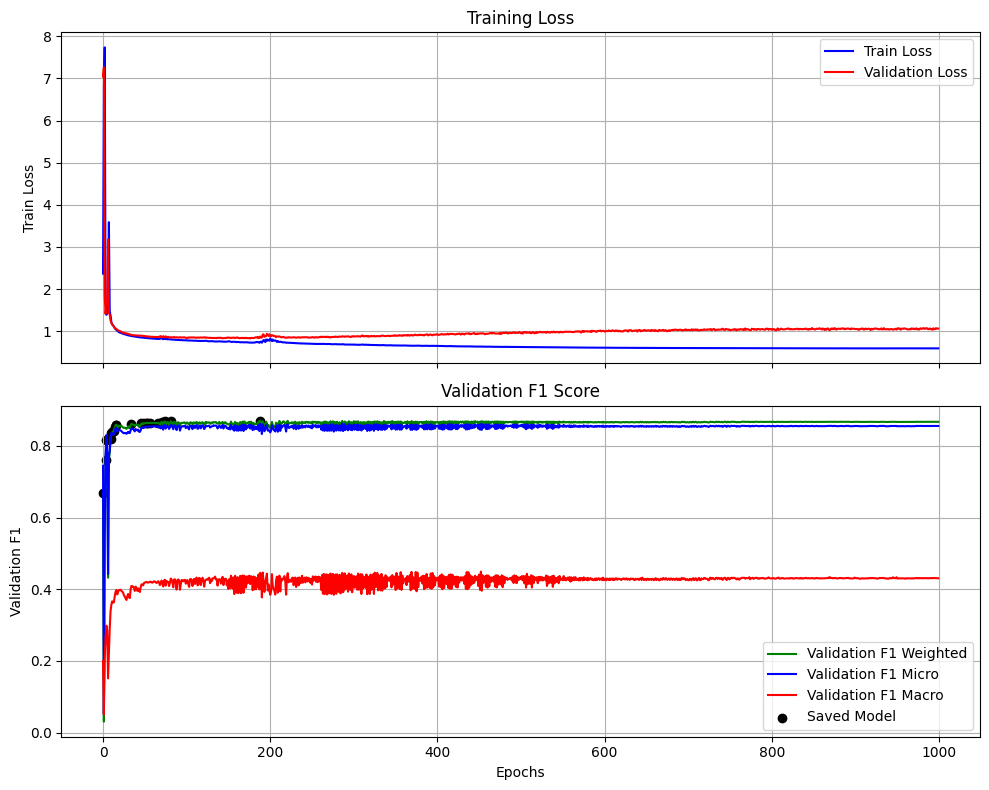

In [25]:
plot_training_process(train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

In [26]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(dataset, adversarial=False):

    best_model = EGraphSAGE(node_in_channels=num_features, 
                       edge_in_channels=num_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=num_classes).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path, weights_only=True))

    best_model.eval()

    print("inference start")
    with th.no_grad():
        all_pred_logits = []
        all_test_labels = []
        for G_pyg in tqdm(dataset, desc="Evaluation", leave=False):
            try:
                # Move the graph data to the device
                G_pyg = G_pyg.to(device)
                G_pyg.edge_label = G_pyg.edge_label.to(device)
                G_pyg.edge_attr = G_pyg.edge_attr.to(device)
                out = best_model(G_pyg)
                
            except Exception as forward_error:
                print(f"Error during forward/backward pass at {forward_error}")

            all_pred_logits.append(out.cpu())
            all_test_labels.append(G_pyg.edge_label.cpu())

        all_pred_logits = th.cat(all_pred_logits).to(device)
        all_test_labels = th.cat(all_test_labels).to(device)
        test_accuracy = compute_accuracy(all_pred_logits, all_test_labels)
        print(f'Test Accuracy: {test_accuracy:.4f}')

        pred_labels = all_pred_logits.argmax(dim=1).cpu()
        all_test_labels = all_test_labels.cpu()
    
    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)


    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4)
    print(report)

print("Number of test graphs: ", len(test_graph_dataset))
eval(test_graph_dataset)


Number of test graphs:  408
Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/split_random_window_raw_port/best_model_all_downsampled.pth
inference start


Evaluation:  18%|█▊        | 75/408 [00:00<00:00, 741.85it/s]

Test Accuracy: 0.8801
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[  177    19   219     0     9     0     0     4     5     0]
 [   77    27   183    16     7     0     0    11    25     0]
 [  213   168  1586   157    83     7     1   109   123     2]
 [  463   270  1932  1769   462    44    11   610   815    16]
 [  172    48   254    78  2719     0     5    97   111     1]
 [   72    88   239   175   278 31258     2   145   117     3]
 [   46     4     5    64   296     6 33391    34    77     7]
 [   44    43   299   302   258    26     4   740   237    18]
 [    0     2     2     7    20     2     0    11   145     0]
 [    0     0     1    10     4     0     0     5     6     2]]
                precision    recall  f1-score   support

      Analysis     0.1400    0.4088    0.2086       433
     Backdoors     0.0404    0.0780    0.0532       346
           DoS     0.3360    0.6476    0.4425      2449
   

In [27]:
def inject_traffic_to_attacker(graph, ratio=0.1, num_injected_nodes=1, is_attack=False):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # 1. Identify attacker nodes
    attacker_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
    attacker_nodes = th.unique(edge_index[:, attacker_edges])
    if attacker_nodes.numel() == 0:
        # raise ValueError("No attacker nodes found.")
        return graph

    # 2. Sample benign edge feature pool
    if is_attack:
        attack_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[attack_edges]
    else:
        benign_edges = (edge_label == BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[benign_edges]

    # 3. Inject new nodes
    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []

    
    for _ in range(num_to_inject):
        src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes

        dst = attacker_nodes[random.randint(0, len(attacker_nodes) - 1)].item()

        new_edges.append([src, dst])
        attr = inject_edge_attr_pool[random.randint(0, len(inject_edge_attr_pool) - 1)]
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

        # new_graph.first_injected_node_idx = original_num_nodes # Store injected node indices

    return new_graph


In [28]:
# Inject Attack Traffic to Attacker Nodes
injected_graph_dataset = [inject_traffic_to_attacker(g.cpu(), 0.1, num_injected_nodes=1, is_attack=True) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/split_random_window_raw_port/best_model_all_downsampled.pth
inference start


Test Accuracy: 0.7507
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [ 277  350  310  806 2570   19  456  989  805   18    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[  270    30    14     0     1     0    24     1     4    89]
 [  165    29    20     5    16     3    19     3     9    77]
 [ 1155    60   200    49    76     9   150    28    76   646]
 

In [29]:
# Inject BENIGN Traffic to Attacker Nodes
injected_graph_dataset = [inject_traffic_to_attacker(g.cpu(), 0.1, num_injected_nodes=1, is_attack=False) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/split_random_window_raw_port/best_model_all_downsampled.pth
inference start


Test Accuracy: 0.7784
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [ 187   70   79 1466  327    1 3507  318  637    8    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[  127    99    74    29     0    71    27     0     6     0]
 [   60    84    68    35     2    55    28     3    11     0]
 [  232   652   548   341    13   345   216    15    85     2]
 

In [30]:
def inject_random_nodes(graph, ratio=0.1, num_injected_nodes=1):
	edge_index = graph.edge_index.clone()
	edge_attr = graph.edge_attr.clone()
	edge_label = graph.edge_label.clone()
	x = graph.x.clone()

	num_edges = edge_index.size(1)
	feature_dim = graph.x.size(1)

	# 1. Inject new nodes
	original_num_nodes = x.size(0)
	new_node_feats = th.ones((num_injected_nodes, feature_dim))
	x = th.cat([x, new_node_feats], dim=0)

	# 2. Inject random edges
	num_to_inject = max(1, int(ratio * num_edges))
	new_edges = []
	new_attrs = []
	new_labels = []

	for _ in range(num_to_inject):
		src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
		dst = random.randint(0, original_num_nodes - 1)  # to existing nodes

		new_edges.append([src, dst])
		attr = edge_attr[random.randint(0, len(edge_attr) - 1)]  # Randomly sample edge attributes
		new_attrs.append(attr)
		new_labels.append(ADVERSARIAL_CLASS_LABEL)  # Assign benign class label to new edges

	# 3. Merge into graph
	if new_edges:
		new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
		new_attrs = th.stack(new_attrs)
		new_labels = th.tensor(new_labels, dtype=th.long)

		edge_index = th.cat([edge_index, new_edges], dim=1)
		edge_attr = th.cat([edge_attr, new_attrs], dim=0)
		edge_label = th.cat([edge_label, new_labels], dim=0)

	# Create a new graph with the injected nodes and edges
	new_graph = Data(
		edge_index=edge_index,
		edge_attr=edge_attr,
		edge_label=edge_label,
		x=x
	)

	return new_graph

In [31]:
# Inject Random Nodes in the graph
injected_graph_dataset = [inject_random_nodes(g.cpu(), 0.1, num_injected_nodes=1) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/split_random_window_raw_port/best_model_all_downsampled.pth
inference start


Test Accuracy: 0.7637
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [ 140  444  281  726  911  105 4230  641  669   13    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[  246    17    57     0     1     0     8     2     4    98]
 [  128    22    48    13     6     5    16     4    16    88]
 [  692   134   478   112    89    32    95    53    83   681]
 